# Análise de Sentimento de Reviews Usando VADER e RoBERTa  
  
Trabalho referente ao Projeto Final da Cadeira de Processamento de Linguagem Natural, do curso de Ciência de Dados e Inteligência Artifical, da Universidade Federal da Paraíba.  

Grupo: Ana Paula Kendall, Rhuan Gabriel do Nascimento Galdino

O presente trabalho tem dois objetivos principais:

1. Usar os modelos de PLN escolhidos para classificar as reviews contidas no dataset com base nos sentimentos interpretados no texto, sendo esses sentimentos positivos, negativos ou neutros;
2. Fazer um comparativo dos resultados obtidos através dos modelos em relação às avaliações, em estrelas, dados pelos próprios autores das reviews.

Supondo que a avaliação em estrelas é uma métrica mais fiel, ou mais facilmente identificável, do sentimento do usuário em relação ao produto, acreditamos que o comparativo dos resultados com as avaliações pode indicar uma possível taxa de acurácia da classificação através dos modelos.


# Importação e tratamento de dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#métricas de validação
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

In [ ]:
#VADER
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#RoBERTa
import torch
from transformers import AutoTokenizer #tokeniza de forma similar ao nltk
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax #suaviza o output entre 0 e 1

Importar dataset

In [ ]:
df = pd.read_csv('Reviews.csv')

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Limpeza do dataset:

In [ ]:
df.shape

(568454, 10)

In [ ]:
#Diminuir número de linhas
df = df.head(5000)

In [ ]:
#Eliminar colunas desnecessárias:
df = df.drop(columns = ['ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'ProductId', 'UserId'])
df.head()

,Id,Score,Summary,Text
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,5,Great taffy,Great taffy at a great price. There was a wid...


Criar coluna com a label "Sentiment" de acordo com a seguinte classificação:  

* de 1 a 2 estrelas: negative  
* 3 estrelas: neutral  
* de 4 a 5 estrelas: positive

In [ ]:
df['Sentiment'] = df['Score'].apply(lambda x: 'negative' if x <= 2 else ('neutral' if x == 3 else 'positive'))

In [ ]:
df.head()

,Id,Score,Summary,Text,Sentiment
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,5,Great taffy,Great taffy at a great price. There was a wid...,positive


## Visualização

Classificação em estrelas

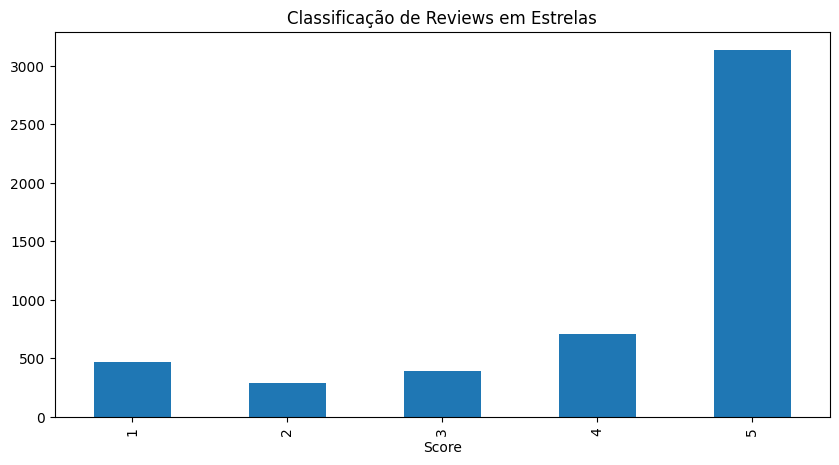

In [ ]:
#Gráfico de barras mostrando quantas reviews para cada classificação (estrelas)
ax = df['Score'].value_counts().sort_index() \
      .plot(kind='bar', title='Classificação de Reviews em Estrelas', figsize=(10,5))
plt.show()

Observa-se um bias significativo para reviews positivas


Classificação em sentimentos

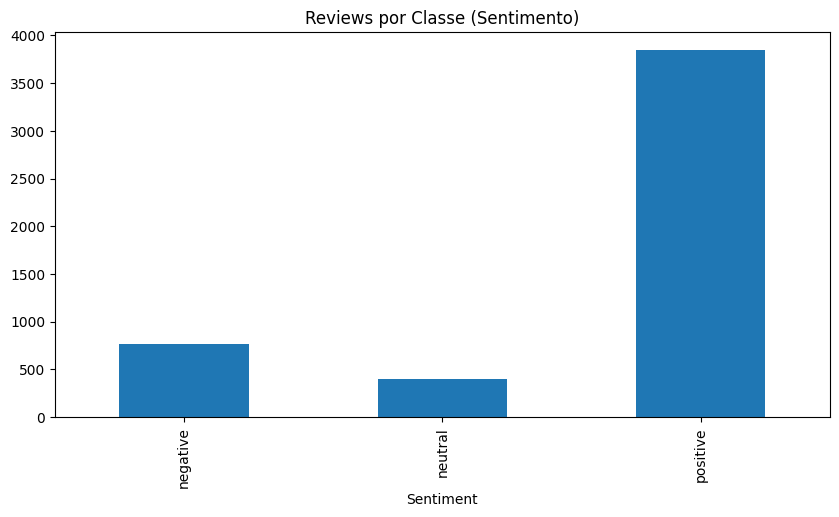

In [ ]:
#Gráfico de barras mostrando quantas reviews para cada classificação (sentimento)
ax = df['Sentiment'].value_counts().sort_index() \
      .plot(kind='bar', title='Reviews por Classe (Sentimento)', figsize=(10,5))
plt.show()

# VADER

O VADER (Valence Aware Dictionary and Sentiment Reasoner), através da função `SentimentIntensityAnalyzer` atribui pontuações negativas, positivas ou neutras para cada palavra. Ao combinar essas pontuações, observa-se a tendência geral do texto.

- As pontuações são atribuídas no intervalo [-1,1], sendo -1 a mais negativa, 0 a mais neutra e 1 a mais positiva


In [ ]:
sia = SentimentIntensityAnalyzer()

Observando o funcionamento do sia

In [ ]:
sia.polarity_scores('I am sad.')

{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}

In [ ]:
sia.polarity_scores('This was the best day ever!')

{'neg': 0.0, 'neu': 0.527, 'pos': 0.473, 'compound': 0.6696}

Usando um exemplo do dataset:

In [ ]:
example = df['Text'][1]
print(example)

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


In [ ]:
sia.polarity_scores(example)

{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664}

Observa-se que, ao atribuir as pontuações, o sia tende para o neutro.

Rodando o sia no dataset inteiro:

In [ ]:
vader_results = {}

# Criar lista de tuplas para iterar de forma eficiente
id_text_pairs = zip(df['Id'], df['Text'])

vader_results = {rowId: sia.polarity_scores(text) for rowId, text in tqdm(id_text_pairs, total=len(df))} # O tqdm envolve o iterador zip para mostrar a barra de progresso


print(f"Análise com VADER concluída para {len(vader_results)} reviews.")

  0%|          | 0/5000 [00:00<?, ?it/s]

Análise com VADER concluída para 5000 reviews.


In [ ]:
vader_results_df = pd.DataFrame(vader_results).T
vader_results_df = vader_results_df.rename(columns={'neg': 'vader_neg', 'neu': 'vader_neu', 'pos': 'vader_pos', 'compound': "vader_compound"})
vader_results_df.head()

,vader_neg,vader_neu,vader_pos,vader_compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468


Criar coluna com a label "Sentiment" de acordo com a seguinte classificação:  

* compound score <= -0.5: negative  
* -0.5 < compound score < 0.5: neutral
* compound score >= 0.5: positive

In [ ]:
vader_results_df['vader_Sentiment'] = vader_results_df['vader_compound'].apply(lambda x: 'negative' if x <= -0.5 else ('positive' if x >= 0.5 else 'neutral'))

In [ ]:
vader_results_df.head()

,vader_neg,vader_neu,vader_pos,vader_compound,vader_Sentiment
1,0.000,0.695,0.305,0.9441,positive
2,0.138,0.862,0.000,-0.5664,negative
3,0.091,0.754,0.155,0.8265,positive
4,0.000,1.000,0.000,0.0000,neutral
5,0.000,0.552,0.448,0.9468,positive


Em contexto:

In [ ]:
vader_context = vader_results_df.reset_index().rename(columns={'index': 'Id'})
vader_context = vader_context.merge(df, how='left')
vader_context.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,vader_Sentiment,Score,Summary,Text,Sentiment
0,1,0.000,0.695,0.305,0.9441,positive,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,0.138,0.862,0.000,-0.5664,negative,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,0.091,0.754,0.155,0.8265,positive,4,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,0.000,1.000,0.000,0.0000,neutral,2,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,0.000,0.552,0.448,0.9468,positive,5,Great taffy,Great taffy at a great price. There was a wid...,positive


## Visualização VADER

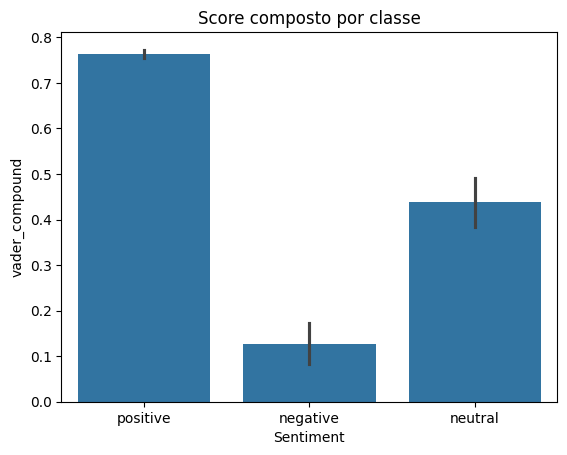

In [ ]:
ax = sns.barplot(data=vader_context, x='Sentiment', y='vader_compound')
ax.set_title('Score composto por classe')
plt.show()

Scores do VADER por Classificação em Estrelas

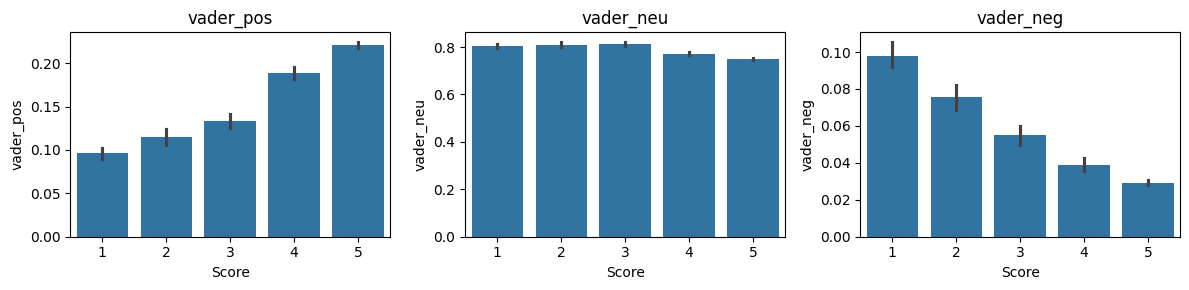

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vader_context, x='Score', y='vader_pos', ax=axs[0])
sns.barplot(data=vader_context, x='Score', y='vader_neu', ax=axs[1])
sns.barplot(data=vader_context, x='Score', y='vader_neg', ax=axs[2])
axs[0].set_title('vader_pos')
axs[1].set_title('vader_neu')
axs[2].set_title('vader_neg')
plt.tight_layout()
plt.show()

- O valor de score **positivo** das reviews tende a **crescer** conforme a avaliação em estrelas sobe  
- O valor de score **neutro** das reviews se **mantém estável** conforme a avaliação em estrelas sobe  
- O valor de score **negativo** das reviews tende a **decrescer** conforme a avaliação em estrelas sobe



# RoBERTa  

Roberta é um modelo pré treinado da pipeline 🤗 Huggingface, sendo uma evolução do BERT, modelo de deeplearning baseado em Transformers.


- Treinado em um grande corpus de dados (posts no Twitter), especificamente para análise de sentimento
- Considera o contexto no qual as palavras estão inseridas

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Rodar Roberta na review de exemplo:

In [ ]:
print(example)

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


In [ ]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy() #transformar o formato de tensor para numpy
scores = softmax(scores)

print("neg: ", scores[0], ", neu: ", scores[1], ", pos: ", scores[2])

neg:  0.50898606 , neu:  0.45241356 , pos:  0.038600385


Rodar no dataset inteiro:

In [ ]:
'''
batch_size = 32

rob_results = {}
sentiment_map = ['negative', 'neutral', 'positive']

for i in tqdm(range(0, len(df), batch_size)):

    # Pegar os textos e Ids do batch atual
    batch_texts = df.iloc[i:i + batch_size]['Text'].tolist()
    batch_ids = df.iloc[i:i + batch_size]['Id'].tolist()
    #codificar os textos do batch
    encoded_text = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)

    with torch.no_grad(): # Desativa o cálculo de gradientes para acelerar
      output = model(**encoded_text)

    scores = output.logits.detach().numpy() #transformar de tensor para numpy array
    probabilities = softmax(scores, axis=1)

    #Preencher o dicionario de resultados
    for j in range(len(probabilities)):
        row_id = batch_ids[j]
        single_probs = probabilities[j]
        label_index = single_probs.argmax() # Pega o índice do sentimento com maior score

        rob_results[row_id] = {
            'rob_neg': single_probs[0],
            'rob_neu': single_probs[1],
            'rob_pos': single_probs[2],
            'rob_Sentiment': sentiment_map[label_index]
        }

print(f"Processamento concluído. {len(rob_results)} reviews analisados.")
'''

  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', truncation=True, max_length=512) #truncar tokens maiores que 512 (limite do modelo)
    output = model(**encoded_text)

    #classificar
    probs = torch.nn.functional.softmax(output.logits, dim=1)
    label = torch.argmax(probs, dim=1).item()
    sentiment = ['negative', 'neutral', 'positive'][label]

    #calcular scores individuais
    scores = output[0][0].detach().numpy() #transformar de tensor para numpy array
    scores = softmax(scores)

    scores_dict = {
        'rob_neg' : scores[0],
        'rob_neu' : scores[1],
        'rob_pos' : scores[2],
        'rob_Sentiment': sentiment
    }
    return scores_dict


In [ ]:

rob_results = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  rowId = row['Id']
  rob_results[rowId] = polarity_scores_roberta(text)



  0%|          | 0/5000 [00:00<?, ?it/s]

Transformando os resultados em um dataframe:

In [ ]:
rob_results_df = pd.DataFrame(rob_results).T
rob_results_df = rob_results_df.reset_index().rename(columns={'index': 'Id'})
rob_results_df.head()

,Id,rob_neg,rob_neu,rob_pos,rob_Sentiment
0,1,0.009624,0.04998,0.940395,positive
1,2,0.508986,0.452414,0.0386,negative
2,3,0.003229,0.098067,0.898704,positive
3,4,0.002295,0.090219,0.907486,positive
4,5,0.001635,0.010302,0.988063,positive


Em contexto:

In [ ]:
rob_context = rob_results_df.merge(df, how='left')
rob_context.head()

,Id,rob_neg,rob_neu,rob_pos,rob_Sentiment,Score,Summary,Text,Sentiment
0,1,0.009624,0.04998,0.940395,positive,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,0.508986,0.452414,0.0386,negative,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,0.003229,0.098067,0.898704,positive,4,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,0.002295,0.090219,0.907486,positive,2,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,0.001635,0.010302,0.988063,positive,5,Great taffy,Great taffy at a great price. There was a wid...,positive


### Visualizações Roberta

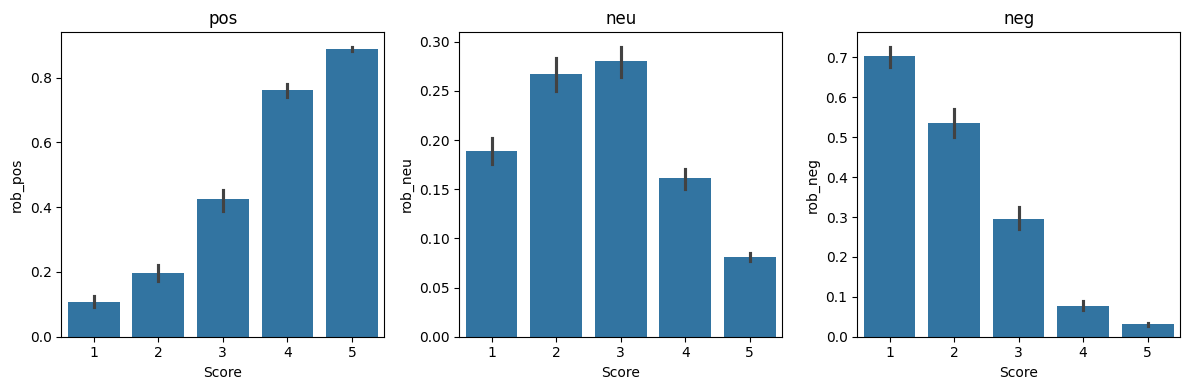

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
sns.barplot(data=rob_context, x='Score', y='rob_pos', ax=axs[0])
sns.barplot(data=rob_context, x='Score', y='rob_neu', ax=axs[1])
sns.barplot(data=rob_context, x='Score', y='rob_neg', ax=axs[2])
axs[0].set_title('pos')
axs[1].set_title('neu')
axs[2].set_title('neg')
plt.tight_layout()
plt.show()

- O valor de score **positivo** das reviews tende a **crescer** conforme a avaliação em estrelas sobe  
- O valor de score **neutro** é **maior nas reviews de avaliação média** e decresce conforme a avaliação em estrelas sobre ou desce.
- O valor de score **negativo** das reviews tende a **decrescer** conforme a avaliação em estrelas sobe


## Experimentos para validação dos resultados

In [ ]:
results_df = rob_results_df.merge(vader_context, how='left')
results_df.head()

,Id,rob_neg,rob_neu,rob_pos,rob_Sentiment,vader_neg,vader_neu,vader_pos,vader_compound,vader_Sentiment,Score,Summary,Text,Sentiment
0,1,0.009624,0.04998,0.940395,positive,0.000,0.695,0.305,0.9441,positive,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,0.508986,0.452414,0.0386,negative,0.138,0.862,0.000,-0.5664,negative,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,0.003229,0.098067,0.898704,positive,0.091,0.754,0.155,0.8265,positive,4,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,0.002295,0.090219,0.907486,positive,0.000,1.000,0.000,0.0000,neutral,2,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,0.001635,0.010302,0.988063,positive,0.000,0.552,0.448,0.9468,positive,5,Great taffy,Great taffy at a great price. There was a wid...,positive


### 1. Comparação das classificações de maior erro

Observar os exemplos em que a classificação dos modelos e a avaliação em estrelas mais diferem.

#### Reviews de 1 estrela classificados como positivos



RoBERTa

In [ ]:
results_df.query('Score == 1') \
    .sort_values('rob_pos', ascending=False)['Text'].values[0] #seleciona a review de maior score positivo

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

Análise: A review realmente tem teor positivo e provavelmente foi avaliada com 1 estrela po erro do usuário

Vader

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

"Second ingredient is SUGAR! Need I say more? Make your own bisquit mix, it's super easy!"

Análise: O modelo falhou em detectar a conotação negativa no emprego de expressões positivas como "SUGAR!" e "it's super easy!"

#### Reviews de 5 estrelas classificados como negativos

RoBERTa

In [ ]:
results_df.query('Score == 5') \
    .sort_values('rob_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

Vader

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

Análise: Ambos os modelos falharam em detectar o sarcasmo nessa review.

### 2. Métricas de Validação

In [ ]:
def evaluate_model(y_true, y_pred, nome_modelo):
    print(f'\n Resultados para {nome_modelo}')
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    print(f'Acurácia:  {acc:.3f}')
    print(f'Precisão:  {precision:.3f}')
    print(f'Recall:    {recall:.3f}')
    print(f'F1-score:  {f1:.3f}')

    print('\nRelatório completo:')
    print(classification_report(y_true, y_pred, digits=3))

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'Confusion Matrix {nome_modelo}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

#### Vader


 Resultados para VADER
Acurácia:  0.737
Precisão:  0.568
Recall:    0.487
F1-score:  0.481

Relatório completo:
              precision    recall  f1-score   support

    negative      0.674     0.237     0.351       759
     neutral      0.161     0.347     0.220       395
    positive      0.868     0.876     0.872      3846

    accuracy                          0.737      5000
   macro avg      0.568     0.487     0.481      5000
weighted avg      0.782     0.737     0.741      5000



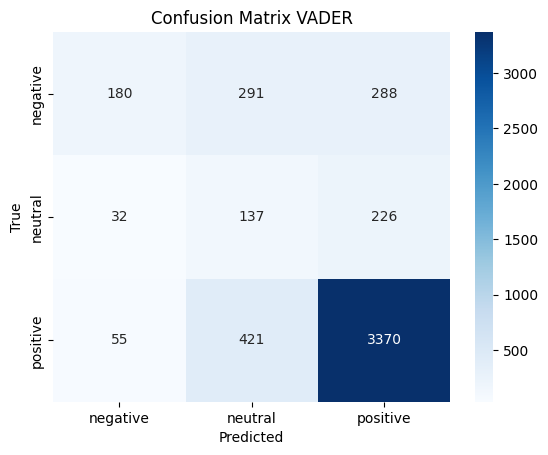

In [ ]:
evaluate_model(results_df['Sentiment'], results_df['vader_Sentiment'], 'VADER')

#### RoBERTa


 Resultados para RoBERTa
Acurácia:  0.849
Precisão:  0.630
Recall:    0.630
F1-score:  0.629

Relatório completo:
              precision    recall  f1-score   support

    negative      0.722     0.747     0.734       759
     neutral      0.239     0.208     0.222       395
    positive      0.928     0.934     0.931      3846

    accuracy                          0.849      5000
   macro avg      0.630     0.630     0.629      5000
weighted avg      0.843     0.849     0.845      5000



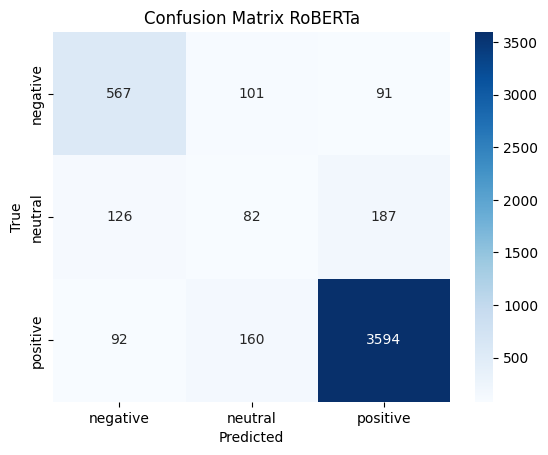

In [ ]:
evaluate_model(results_df['Sentiment'], results_df['rob_Sentiment'], 'RoBERTa')

### 3. Comparação de Scores entre os modelos

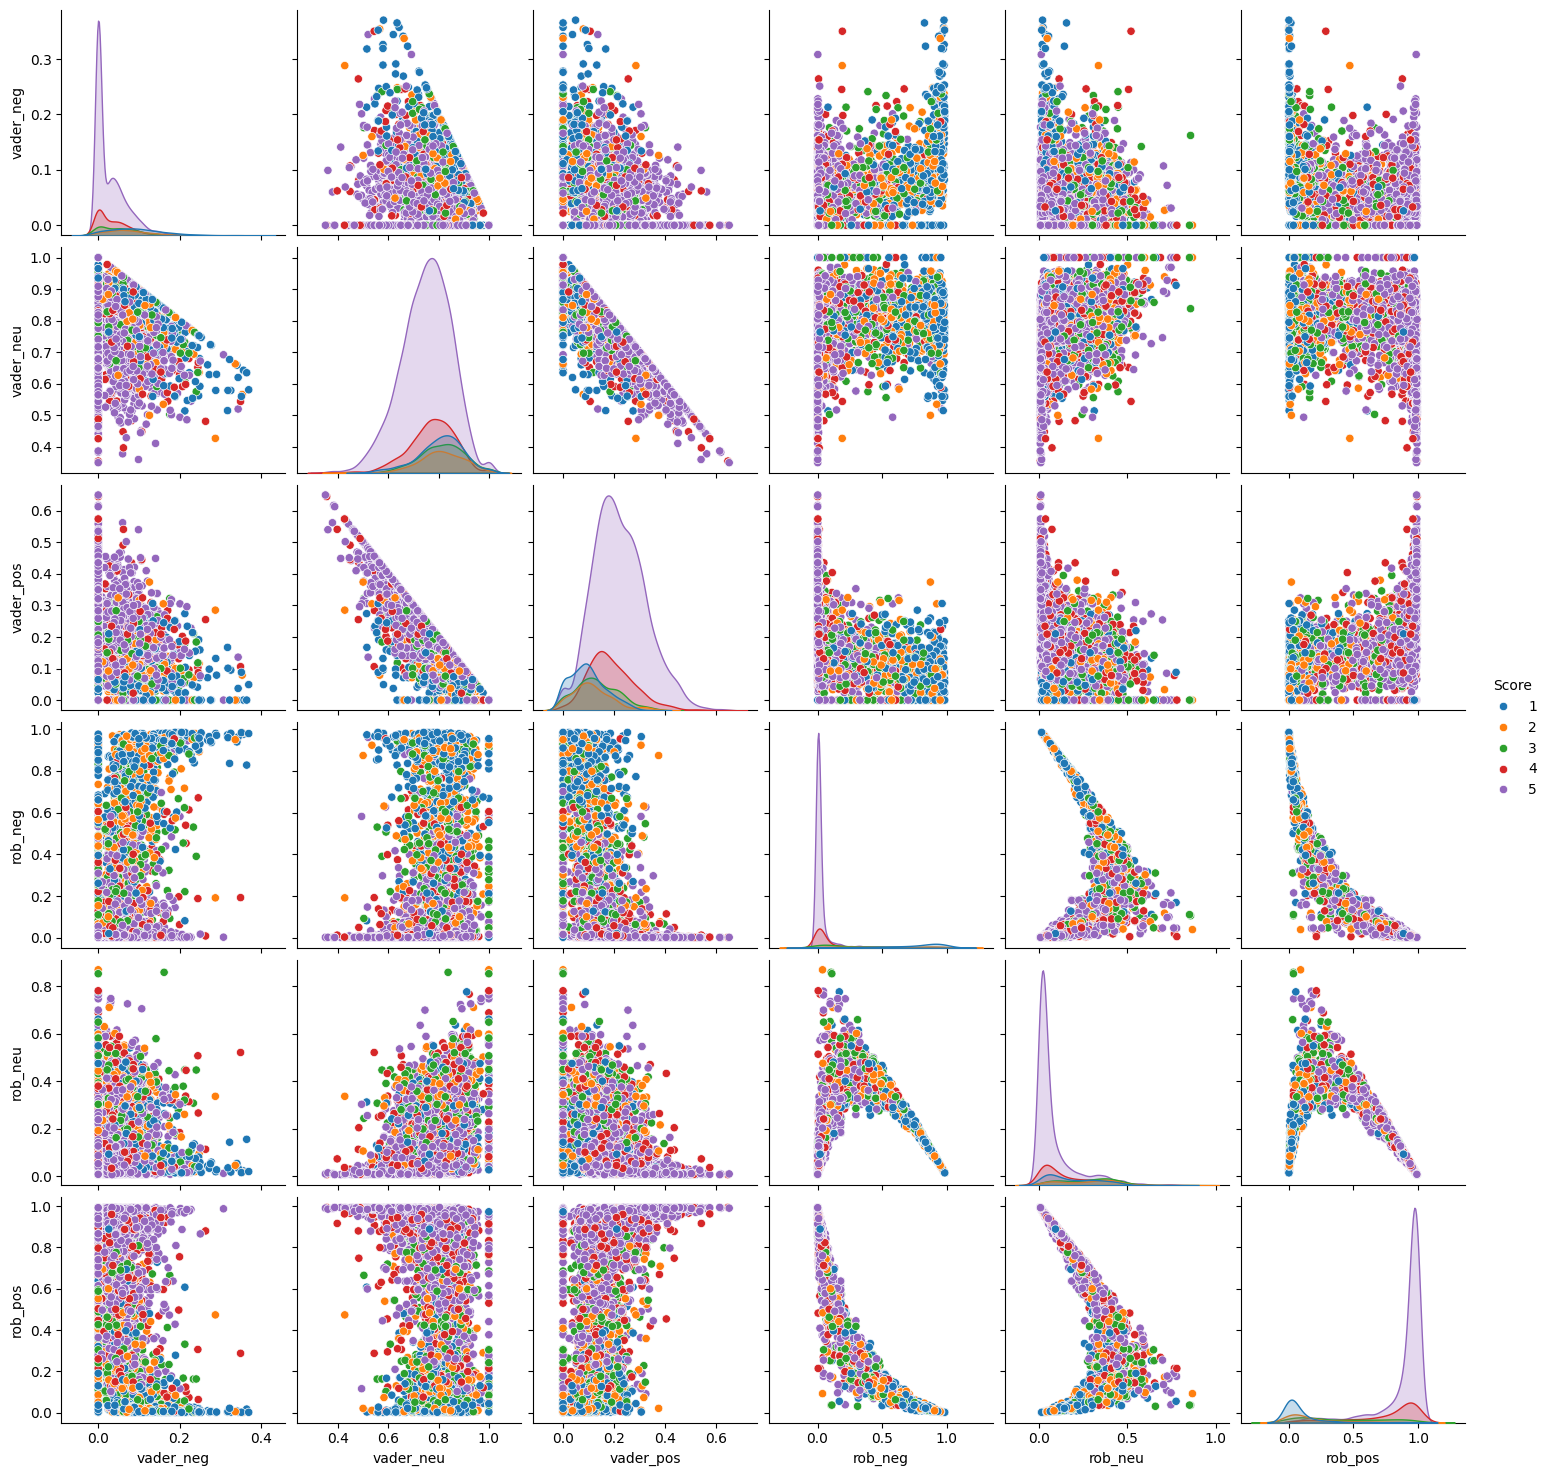

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'rob_neg', 'rob_neu', 'rob_pos'],
            hue='Sentiment')
plt.show()

Comparação entre as distribuições das classificações

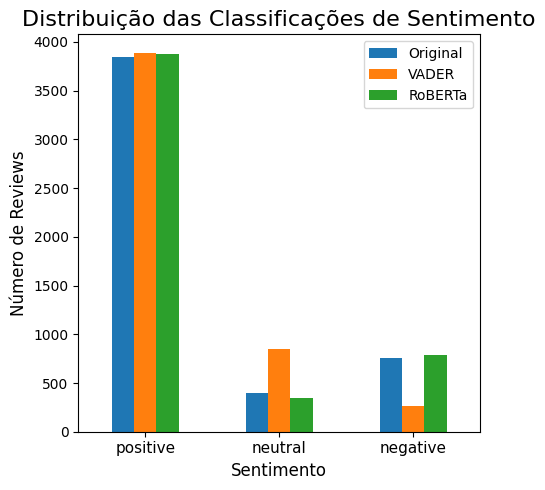

In [ ]:
# Contar os sentimentos de cada coluna
original_counts = results_df['Sentiment'].value_counts()
vader_counts = results_df['vader_Sentiment'].value_counts()
roberta_counts = results_df['rob_Sentiment'].value_counts()

# Juntar tudo em um dataframe
comparison_df = pd.DataFrame({
    'Original': original_counts,
    'VADER': vader_counts,
    'RoBERTa': roberta_counts
})

# Reordenar as linhas para melhor visualização
comparison_df = comparison_df.reindex(['positive', 'neutral', 'negative'])

ax = comparison_df.plot(kind='bar', figsize=(5, 5))

# Título e rótulos
ax.set_title('Distribuição das Classificações de Sentimento', fontsize=16)
ax.set_ylabel('Número de Reviews', fontsize=12)
ax.set_xlabel('Sentimento', fontsize=12)
ax.tick_params(axis='x', rotation=0, labelsize=11) # Deixa os rótulos do eixo X na horizontal


# Mostrar o gráfico
plt.tight_layout()
plt.show()